In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from variational_auto_encoder import VariationalAutoEncoder
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np
import matplotlib.pyplot as plt
from verification_net import VerificationNet
from utils import display_images

In [64]:
variational_auto_encoder = VariationalAutoEncoder(latent_dim=8)
variational_auto_encoder.model.summary()
variational_auto_encoder.train(force_relearn=False)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 13, 13, 32)        320       
                                                                 
 conv2d_45 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 flatten_26 (Flatten)        (None, 2304)              0         
                                                                 
 dense_32 (Dense)            (None, 16)                36880     
                                                                 
 independent_normal_10 (Inde  ((None, 8),              0         
 pendentNormal)               (None, 8))                         
                                                          

# Mono Images

In [65]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

### Reconstruction results

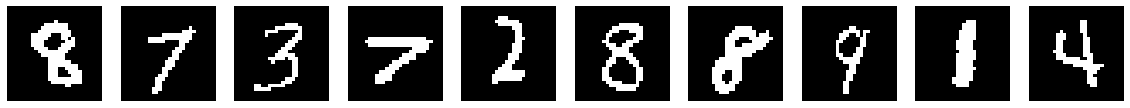

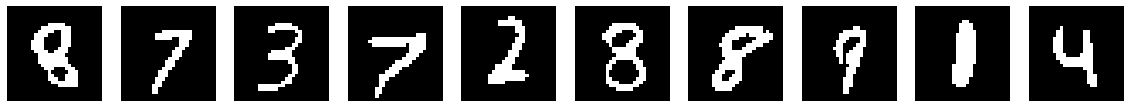

In [66]:
reconstructed = variational_auto_encoder.reconstruct(x_test)

display_images(x_test, 10)
display_images(reconstructed, 10)

In [67]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")


Accuracy of Reconstruction: 83.10%


### Autoencoder as a generator

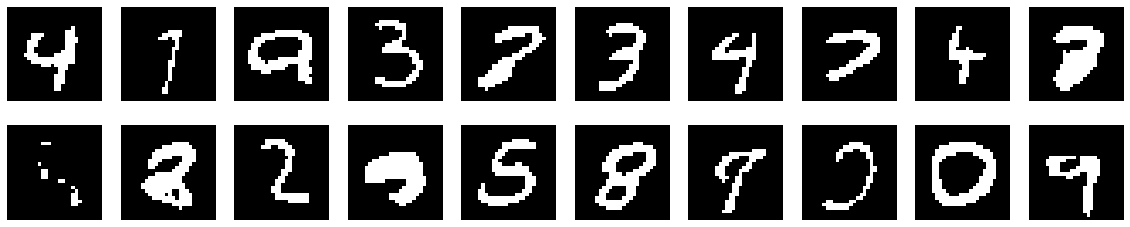

In [68]:
generated = variational_auto_encoder.generate_new_samples()
display_images(generated, 20)

In [69]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 75.20%


# Color Images

In [70]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)
x_test = x_test.astype(np.float64)

### Reconstruction results

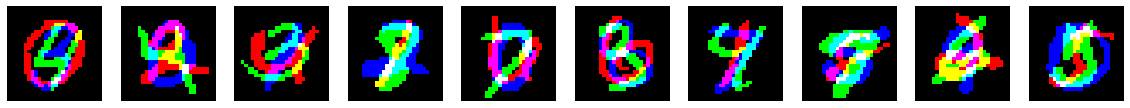

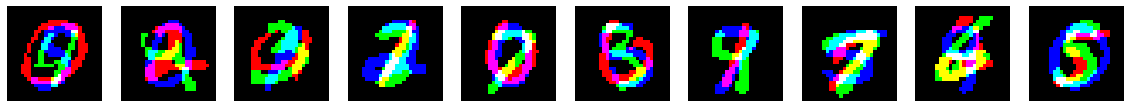

In [71]:
reconstructed = variational_auto_encoder.reconstruct(x_test)

display_images(x_test, 10, color=True)
display_images(reconstructed, 10, color=True)

In [74]:
net = VerificationNet(force_learn=False, file_name="../models/verification_model")
_, acc_ae = net.check_predictability(data=reconstructed, correct_labels=y_test, tolerance=0.5)
_, acc_or = net.check_predictability(data=x_test, correct_labels=y_test, tolerance=0.5)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")

/usr/local/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy of Reconstruction: 60.75%
Accuracy of Reconstruction: 94.75%


### Variational-Auto-Encoder as a generator

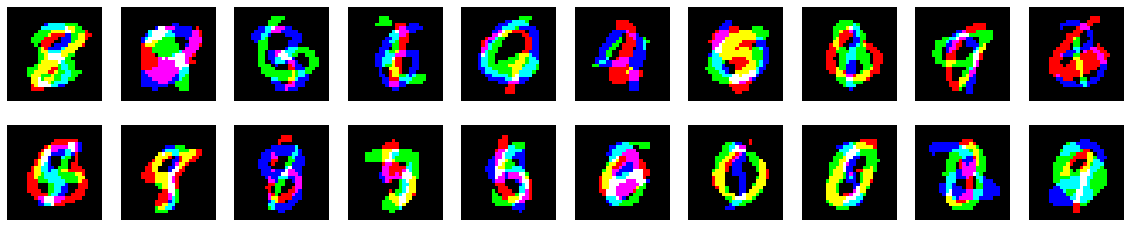

In [48]:
generated = variational_auto_encoder.generate_new_samples(no_channels=3)
display_images(generated, 20, color=True)

In [49]:
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 16.10%
Predictability: 44.30%


# Variational-Auto-Encoder as anomaly detector

In [60]:
vae_anomaly = VariationalAutoEncoder(latent_dim=8, missing=True)
vae_anomaly.train(force_relearn=False)

./models/vae_missing
Read model from file, so I do not retrain


### Mono images

IndexError: index 10 is out of bounds for axis 0 with size 10

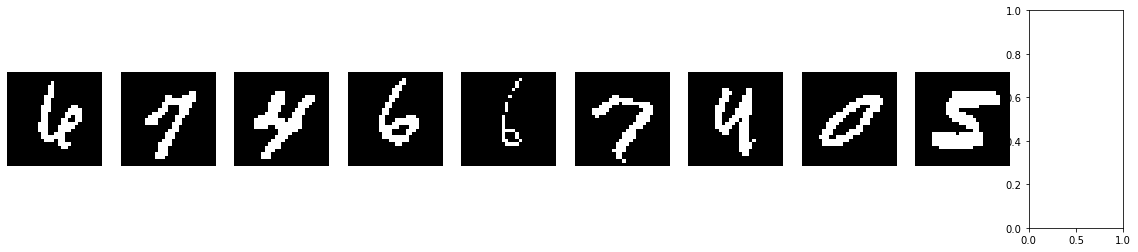

In [53]:
generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)

anomalies = vae_anomaly.get_anomalies(x_test)
display_images(x_test[anomalies], 10)

### Color images

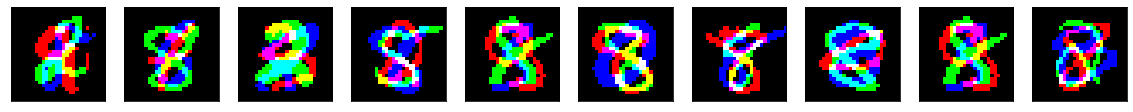

In [ ]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)
x_test, y_test = generator.get_random_batch(training=False, batch_size=2000)
x_test = x_test.astype(np.float64)

anomalies = vae_anomaly.get_anomalies(x_test, k=10, N=1000)
display_images(x_test[anomalies], 10, color=True)